# Introduction
I am making my very first attempts at understanding Nerual Networks. 

I am familiar with the basic principles, but have never implemented a neural network. 
In this notebook I will implement a neural network to solve a toy problem proposed by Brandon Rohrer in his Youtube video [How Deep Neural Networks Work](https://www.youtube.com/watch?v=dpGQagJEBis).
I will be using the Tensorflow API directly to try to grasps the basic building blocks of a neural network.

The task is to classify the input from a four-pixel camera into four categories:
* Solid color
* Diagonal line
* Vetical line
* Horizontal line

I will only consider black and white pixels, with no color scale. 
In other words the pixels will either have the value 0 or 1.
Lets visualise the valid inputs.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

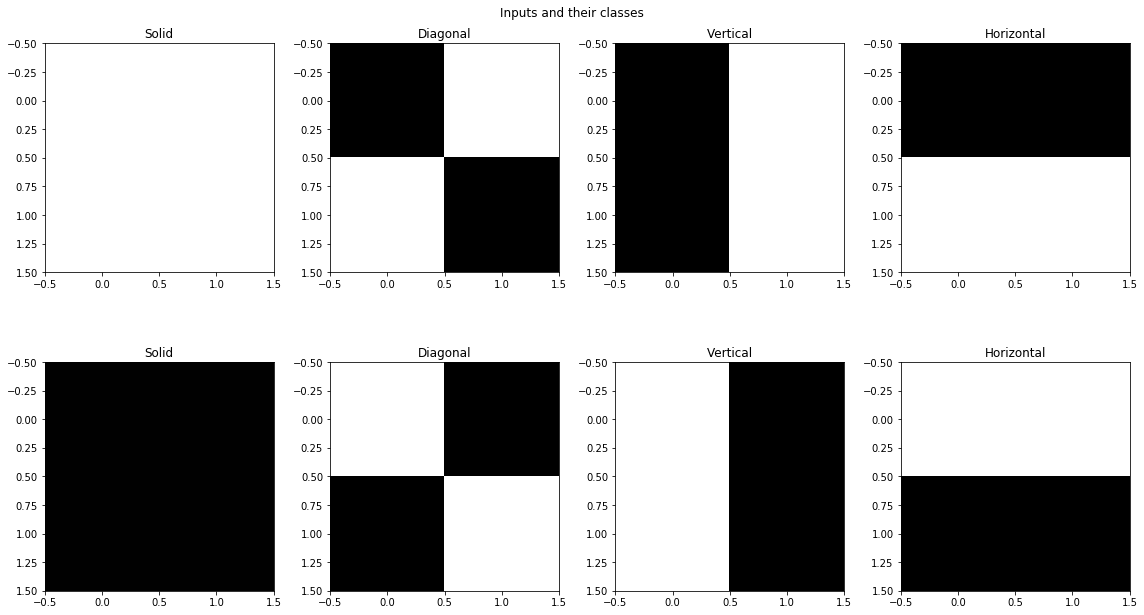

In [50]:
f, ax = plt.subplots(2, 4, figsize=(16,9))

# Solid
ax[0][0].set_title('Solid')
X = np.asarray([0, 0, 0, 0]).reshape(2,2)
ax[0][0].imshow(X, cmap='Greys')
ax[1][0].set_title('Solid')
# Hack as cmap = 'Greys' interprets the minimum value in X as being white.
X = np.asarray([[(255, 255, 255), (255, 255, 255)], [(255, 255, 255), (255, 255, 255)]], dtype = "byte")
ax[1][0].imshow(X)

# Diagonal
ax[0][1].set_title('Diagonal')
X = np.asarray([1, -1, -1, 1]).reshape(2,2)
ax[0][1].imshow(X, cmap='Greys')
ax[1][1].set_title('Diagonal')
X *= -1
ax[1][1].imshow(X, cmap='Greys')

# Vertical
ax[0][2].set_title('Vertical')
X = np.asarray([1, -1, 1, -1]).reshape(2,2)
ax[0][2].imshow(X, cmap='Greys')
ax[1][2].set_title('Vertical')
X *= -1
ax[1][2].imshow(X, cmap='Greys')

# Horizontal
ax[0][3].set_title('Horizontal')
X = np.asarray([1, 1, -1, -1]).reshape(2,2)
ax[0][3].imshow(X, cmap='Greys')
ax[1][3].set_title('Horizontal')
X *= -1
ax[1][3].imshow(X, cmap='Greys')

f.suptitle("Inputs and their classes")
f.tight_layout()

Thats it, this is the complete input space! 
Ideally a neural netowrk should be able to classify all these 8 examples correctly.

I will imitate the structure proposed by Brandon Rohrer in his video:
* Layer 1 - Input
    * 4 Input Nodes, no bias term
* Layer 2 - Hidden Layer
    * 4 Neurons with a sigmoid activation function
* Layer 3 - Hidden Layer
    * 4 Neurons with a sigmoid activation function
* Layer 4 - Hidden Layer
    * 8 Neurons with a rectified linear activation function (ReLU)
* Layer 5 - Output Layer
    * 4 Neurons without an activation function, should represent the probability that the input matches the class that the node represents

# Setting up the Neural Network

In [2]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [3]:
n_inputs = 4
n_outputs = 4
nodes_hidden_layers = [4, 4, 8]

In [47]:
tf.reset_default_graph()

In [48]:
# Define Input Nodes
X = tf.placeholder(tf.float32, shape = (None, n_inputs), name='X')
# The output will be identified by an integer in the range 0..3
y = tf.placeholder(tf.int64, shape = (None), name='y')

In [49]:
# Set up the hidden layers and the output layer
with tf.name_scope('dnn'):
    hidden1 = fully_connected(X, nodes_hidden_layers[0], scope='hidden1', activation_fn=tf.nn.sigmoid)
    hidden2 = fully_connected(hidden1, nodes_hidden_layers[1], scope='hidden2', activation_fn=tf.nn.sigmoid)
    hidden3 = fully_connected(hidden2, nodes_hidden_layers[2], scope='hidden3', activation_fn=tf.nn.relu)
    logits = fully_connected(hidden3, n_outputs, scope='outputs', activation_fn=None)

In [50]:
# Define a loss function
# I will use cross entropy
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name = 'loss')

In [51]:
# Define how to update the weights of the nerual network
# I will use Gradient Descent which
learning_rate = .1

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_operation = optimizer.minimize(loss)

In [52]:
# Define how to evaluate performance
# I will use Accuracy

with tf.name_scope('evaluation'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [53]:
init = tf.global_variables_initializer()

# Defining the data
The data is scaled to 0..1, it is not centered around 0.

In [54]:
data = [
        [0, 0, 0, 0], [1, 1, 1, 1], 
        [1, 0, 0, 1], [0, 1, 1, 0],
        [1, 0, 1, 0], [0, 1, 0, 1],
        [1, 1, 0, 0], [0, 0, 1, 1]
    ]
labels = [0, 0, 1, 1, 2, 2, 3, 3]

# Training the Network

In [55]:
saver = tf.train.Saver()

In [41]:
n_epochs = 10000

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+1):
        sess.run(training_operation, feed_dict= {X: data, y: labels})
        if epoch %1000 == 0:
            acc = accuracy.eval(feed_dict= {X: data, y: labels})
            print("{} epochs passed. Training set accuracy is {}".format(epoch, acc))
            if acc == 1.0:
                break
    acc = accuracy.eval(feed_dict= {X: data, y: labels})
    print("Finished. Training set accuracy is {}".format(acc))
    save_path = saver.save(sess, "./simple_model.ckpt")

1000 epochs passed. Training set accuracy is 0.375
2000 epochs passed. Training set accuracy is 0.375
3000 epochs passed. Training set accuracy is 0.375
4000 epochs passed. Training set accuracy is 0.5
5000 epochs passed. Training set accuracy is 1.0
Finished. Training set accuracy is 1.0


Cool, we reach 100% accuracy!
Lets try using the model, even though we know that the result will be perfect as the training set covers all valid cases.

In [56]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_in = np.asarray(data)
    z = logits.eval(feed_dict={X: X_in})
    y_pred = np.argmax(z, axis=1)

INFO:tensorflow:Restoring parameters from ./simple_model.ckpt


In [58]:
y_pred == labels

array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

Yupp, correct on all training examples as expected! What if we scale the data so that colored pixels are 0.5 instead of 1?

In [62]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_in = np.asarray([np.asarray(instance) * .5 for instance in data])
    z = logits.eval(feed_dict={X: X_in})
    y_pred = np.argmax(z, axis=1)

INFO:tensorflow:Restoring parameters from ./simple_model.ckpt


In [64]:
y_pred

array([0, 1, 1, 1, 3, 1, 1, 1], dtype=int64)

In [63]:
y_pred == labels

array([ True, False,  True,  True, False, False, False, False], dtype=bool)

We can still handle the solid white case, as well as the diagonals.
Most other cases are now classified incorectly. 

# Summary
I implemented a neural network suggested by Brandon Rohrer in Tensorflow and achieved 100% accuracy on his toy problem.

It would be interesting to see if I can train a network with fewer layers or fewer neurons to perform this task.
I heard that scaling up the number of neurons in one layer can allow you to drop later layers, but typically the network will need many more neurons this way. 
It would be interesting to experiment with this tradeoff. 

It would be also interesting to make the problem a little bit harder.
For example, what if I acceoted continuous pixel values in the range ]0,1] for the colored pixels, while still keeping the empty pixels as 0?

Unfotunately I feel that experimenting with these things without rewrting to much code will have me setting up many Tensorflow specific functions etc. 
My utlimate goal is not to master deep learning in Tensorflow, as it feels like a quite verbose framework.
I will most likely try to use a higher level framework such as Keras instead.

For this reason I leav further experiments for another day.